In [1]:
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere
import pylab
from nengo.dists import Choice
% pylab inline

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


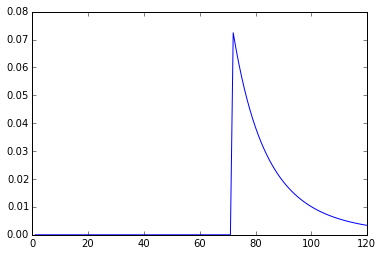

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


alpha_hat:  1
(1, 120)
(120, 120)
[[  1.42198737e+37   1.33430032e+37   1.24967478e+37 ...,   4.11293316e+32
    3.58188941e+32   3.12124982e+32]
 [  1.25965028e+37   1.19895398e+37   1.13829352e+37 ...,   4.77184669e+32
    4.16103099e+32   3.63054024e+32]
 [  1.09937000e+37   1.06207885e+37   1.02282937e+37 ...,   5.52926451e+32
    4.82765005e+32   4.21754798e+32]
 ..., 
 [  2.37065278e-29   2.52097345e-28   2.65446488e-27 ...,   1.27236641e+36
    1.43255917e+36   1.59409571e+36]
 [  1.83945161e-30   1.99882478e-29   2.15064607e-28 ...,   1.12711036e+36
    1.28724583e+36   1.45201683e+36]
 [  1.39676144e-31   1.55094053e-30   1.70520029e-29 ...,   9.83694707e+35
    1.14029111e+36   1.30472978e+36]]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in power


In [17]:

max_age = dim = 120

# likelihood parameters
# observed age data
x = 20
# x_vector = [35, 5, 20, 55, 65, 72]

# prior parameters
skew = -4
loc = 97
scale = 28

# our domain is thetas (i.e., age from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)
alphas = np.linspace(start=1, stop=max_age, num=max_age)

def likelihood_comb(x):
    like = np.ones(max_age)
    x_vector = [x+15, x-15, x, x+35, x+45, x+52]
    for i in x_vector:
        like = np.multiply(like, likelihood(i))    
    like = like * np.power(10,12)
    return like / np.sum(like)
        

def likelihood(x):
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like


def p_matrix():
    p_matrix = np.zeros((len(thetas), len(alphas)))   # p(theta/alpha)
    for x in alphas:
        p_theta = [(st.skewnorm.pdf(p, a=skew, loc=x, scale=scale)) for p in thetas]
        p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
        p_matrix[:, x-1] = p_theta
    return p_matrix   
    

    

pylab.plot(thetas, likelihood_comb(x=x))
pylab.show()

# ----------------------------------------------------------------------------------------
# Solving for prior using empirical bayes approach computationally

comb_likelihood = likelihood_comb(x)

# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_mat = p_matrix()
    
# Now compute p(X/alpha) by marginalizing out theta for each alpha
#comb_likelihood = comb_likelihood/sum(comb_likelihood)  # already normalized in likelihood_comb function
#p_matrix = p_matrix/sum(p_matrix)
marginpost_set = np.dot(comb_likelihood, p_mat)   # this will be a list of dimentions (1 x max_age)  
#pick the max value and find the corresponding alpha
#print marginpost_set
alpha_hat = np.argmax(marginpost_set) + 1


holder = np.zeros((1,len(comb_likelihood)))    # change shape of likelihood from (120,) to (1,120)
holder[0,:] = comb_likelihood
comb_likelihood = holder

print "alpha_hat: ", alpha_hat

print comb_likelihood.shape
print p_mat.shape

print p_mat*np.power(10,50)


In [18]:
lik_space = nengo.dists.Function(likelihood_comb,
                             x=nengo.dists.Uniform(x,x))
data = lik_space.sample(200)
print data.shape
#pylab.plot(thetas, data.T)
#pylab.show()

def p_matrix2():
    p_matrix = np.zeros((len(thetas), len(alphas)))   # p(theta/alpha)
    for x in alphas:
        p_theta = [(st.skewnorm.pdf(p, a=skew, loc=x, scale=scale)) for p in thetas]
        p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
        p_matrix[:, x-1] = p_theta
    return p_matrix.ravel() 

pmatrix_space = nengo.dists.Function(p_matrix2)

#data = pmatrix_space.sample(50)
#pylab.plot(thetas, data.T)
#pylab.show()

'''
pylab.plot(alphas, data.T)
pylab.show()

from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thetas[:,0], alphas[:,1], data.T)
pylab.show()
'''


(200, 120)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


"\npylab.plot(alphas, data.T)\npylab.show()\n\nfrom mpl_toolkits.mplot3d import Axes3D\nfig = pylab.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(thetas[:,0], alphas[:,1], data.T)\npylab.show()\n"

In [19]:
# Now represent the likelihood i.e., P(X/theta) and P(theta/alpha) in neurons
# And then compute P(X/alpha) by marginalizing out theta for each alpha

num_neurons = 50

# Values should stay within the range (-radius,radius)
radius = 1

rng = np.random.RandomState(12) 
num_samples = 4000

model = nengo.Network(seed=12)
with model:  
    
    # define eval points to only represent positive values
    encoders = lik_space.sample(num_neurons, 1, rng=rng)
    #print encoders
    eval_points = lik_space.sample(num_samples, 1, rng=rng)*1000
    print eval_points
    
    
    # Make 2 EnsembleArrays to store the input
    lik = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=comb_likelihood.size, 
                                radius=radius, encoders=encoders[:,10],
                                 eval_points=eval_points[:,10], n_eval_points=eval_points.shape[0],
                                      max_rates = nengo.dists.Uniform(100,200))
    prior = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=p_mat.size, 
                                radius=radius, encoders=encoders[:,10],
                                 eval_points=eval_points[:,10], n_eval_points=eval_points.shape[0],
                                        max_rates = nengo.dists.Uniform(100,200))
    
    # connect inputs to them so we can set their value
    likelihood_in = nengo.Node(output=likelihood_comb(x=x).ravel())    # p(X/theta): matrix of dimension (1, 120)
    prior_in = nengo.Node(output=p_matrix().ravel())   # p(theta/alpha): matrix of dimension (120, 120)
    nengo.Connection(likelihood_in, lik.input)
    nengo.Connection(prior_in, prior.input)
    
   
    
    # The C matix is composed of populations that each contain
    # one element of 'lik' and one element of 'prior'.
    # These elements will be multiplied together in the next step.
    
    # The appropriate encoders make the multiplication more accurate
    #eval_points = rng.uniform(0, 1, size=(50, 2))
    C = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=comb_likelihood.size * p_mat.shape[1],
                                     ens_dimensions=2,
                                     radius=1.5 * radius,
                                     encoders=Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]]))
                                     
    # Now compute the products and do the appropriate summing
    #eval_points = rng.uniform(0, 1, size=(50, 1))
    D = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=comb_likelihood.shape[0] * p_mat.shape[1],
                                     radius=radius)

                                     

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]
 [ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]
 [ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]
 ..., 
 [ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]
 [ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]
 [ 0.          0.          0.         ...,  3.73679084  3.55229534
   3.37834002]]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in power


In [20]:
# Determine the transformation matrices to get the correct pairwise
# products computed.

transformA = np.zeros((C.dimensions, comb_likelihood.size))
transformB = np.zeros((C.dimensions, p_mat.size))

for i in range(comb_likelihood.shape[0]):
    for j in range(comb_likelihood.shape[1]):
        for k in range(p_mat.shape[1]):
            tmp = (j + k * comb_likelihood.shape[1] + i * p_mat.size)
            transformA[tmp * 2][j + i * comb_likelihood.shape[1]] = 1
            transformB[tmp * 2 + 1][k + j * p_mat.shape[1]] = 1
            
print("Likelihood->C")
print(transformA)
print("p_matrix->C")
print(transformB)


def product(x):
    return x[0] * x[1]

# The mapping for this transformation (C->D) is much easier, since we want to
# combine D2 pairs of elements (we sum D2 products together)
transformC = np.zeros((D.dimensions, p_mat.size))
for i in range(p_mat.size):
    transformC[i // p_mat.shape[0]][i] = 1
print("C->D")
print(transformC)

Likelihood->C
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
p_matrix->C
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
C->D
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  1.  1.]]


In [21]:
with model:
    nengo.Connection(lik.output, C.input, transform=transformA)
    nengo.Connection(prior.output, C.input, transform=transformB)
    
    prod = C.add_output("product", product)
    nengo.Connection(prod, D.input, transform=transformC)

In [22]:
with model:
    # probes
    lik_p = nengo.Probe(lik.output, sample_every=0.01, synapse=0.01)
    prior_p = nengo.Probe(prior.output, sample_every=0.01, synapse=0.01)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)

In [23]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(1.0)

Building finished in 0:00:01.                                                   


BuildError: Building <Connection from <Ensemble "0"> to <Node "output">[0:1]>: 'activities' matrix is all zero for <Ensemble "0">. This is because no evaluation points fall in the firing ranges of any neurons.

In [ ]:
plt.subplot(1, 2, 1)
plt.title('A')
plt.plot(sim.trange(dt=0.01), sim.data[lik_p])
plt.subplot(1, 2, 2)
plt.title('B')
plt.plot(sim.trange(dt=0.01), sim.data[prior_p]);

plt.figure()
plt.plot(sim.trange(dt=0.01), sim.data[D_probe])
for d in np.dot(likelihood, p_matrix).flatten():
    plt.axhline(d, color='k')
plt.title("D");

In [21]:
Amat = np.asarray([[0.5, -0.5]])
print Amat.shape
print Amat.size

(1, 2)
2
